# Project 3: Newsvendor Model with Non-Linear Programming

**Optimization Course Project**

This notebook implements:
1. Extended NVM with rush/disposal costs (LP)
2. Price-endogenous joint optimization (QP)
3. Bootstrap uncertainty analysis

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from gurobipy import GRB

np.random.seed(42)
sns.set_style('whitegrid')
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Step 1: Data Loading and Regression

Fit: **Demand = β₀ + β₁ × price + ε**

In [2]:
# Load data (assumes price_demand_data.csv with columns: price, demand)
data = pd.read_csv('price_demand_data.csv')
print(f"Data shape: {data.shape}")
print(data.head())

# Fit regression
X = data['price'].values.reshape(-1, 1)
y = data['demand'].values
reg = LinearRegression().fit(X, y)

beta_0 = reg.intercept_
beta_1 = reg.coef_[0]
residuals = y - reg.predict(X)

print(f"\nRegression: Demand = {beta_0:.2f} + {beta_1:.2f}*price")
print(f"R² = {reg.score(X, y):.4f}")
print(f"Residuals: mean={np.mean(residuals):.4f}, std={np.std(residuals):.2f}")

Data shape: (99, 2)
   price  demand
0   1.05     283
1   0.86     771
2   1.21     185
3   0.94     531
4   0.76    1002

Regression: Demand = 1924.72 + -1367.71*price
R² = 0.6215
Residuals: mean=0.0000, std=149.45


## Step 2-3: Extended NVM with Fixed Price (p=$1)

**LP Formulation:**
```
max (1/n) Σ hᵢ
s.t. hᵢ ≤ (p-g)*Dᵢ + (g-c)*q    [rush case: D > q]
     hᵢ ≤ t*Dᵢ + (p-c-t)*q        [disposal case: q > D]
```

**Parameters:** c=0.5, g=0.75, t=0.15

In [3]:
def solve_fixed_price_nvm(residuals, beta_0, beta_1, p=1.0, c=0.5, g=0.75, t=0.15):
    """Solve Extended NVM with fixed price using LP."""
    # Generate demand scenarios at fixed price
    D = beta_0 + beta_1 * p + residuals
    n = len(D)
    
    # Create model
    m = gp.Model('Fixed_Price_NVM')
    m.setParam('OutputFlag', 0)
    
    # Variables
    q = m.addVar(lb=0, name='quantity')
    h = m.addVars(n, lb=-GRB.INFINITY, name='profit')
    
    # Objective: maximize average profit
    m.setObjective(gp.quicksum(h[i] for i in range(n)) / n, GRB.MAXIMIZE)
    
    # Constraints
    # Profit = Revenue - Cost
    # Rush case (D > q): Profit = p*D - (c*q + g*(D-q)) = (p-g)*D + (g-c)*q
    # Disposal case (q > D): Profit = p*D - (c*q + t*(q-D)) = (p+t)*D - (c+t)*q
    for i in range(n):
        m.addConstr(h[i] <= (p - g) * D[i] + (g - c) * q)
        m.addConstr(h[i] <= (p + t) * D[i] - (c + t) * q)
    
    m.optimize()
    
    if m.status != GRB.OPTIMAL:
        raise RuntimeError(f"Optimization failed with status {m.status}")
    
    return {'q_star': q.X, 'profit': m.objVal, 'demand': D}

# Solve
result_fixed = solve_fixed_price_nvm(residuals, beta_0, beta_1)
print(f"\n=== Fixed Price (p=$1) ===")
print(f"Optimal Quantity: {result_fixed['q_star']:.2f} units")
print(f"Expected Profit:  ${result_fixed['profit']:.2f}")

Set parameter Username
Set parameter LicenseID to value 2700497
Academic license - for non-commercial use only - expires 2026-08-27

=== Fixed Price (p=$1) ===
Optimal Quantity: 471.87 units
Expected Profit:  $231.48


## Step 4: Price-Endogenous Model (Joint Optimization)

**QP Formulation:**
```
max (1/n) Σ [p*(β₀ + β₁*p + εᵢ) + hᵢ]
s.t. hᵢ ≤ (g-c)*q - g*β₁*p - g*(β₀+εᵢ)      [rush case]
     hᵢ ≤ -(c+t)*q + t*β₁*p + t*(β₀+εᵢ)    [disposal case]
     hᵢ ≤ 0  (costs are non-positive)
```

In [4]:
def solve_price_endogenous_qp(residuals, beta_0, beta_1, c=0.5, g=0.75, t=0.15):
    """Solve Price-Endogenous NVM using QP (h = negative costs)."""
    n = len(residuals)
    
    # Create model
    m = gp.Model('Price_Endogenous_QP')
    m.setParam('OutputFlag', 0)
    m.setParam('NonConvex', 2)  # Allow non-convex QP
    
    # Variables
    p = m.addVar(lb=0, name='price')
    q = m.addVar(lb=0, name='quantity')
    h = m.addVars(n, lb=-GRB.INFINITY, ub=0, name='neg_cost')
    
    # Objective: Revenue (quadratic) + negative costs
    revenue = gp.quicksum(p * (beta_0 + residuals[i]) for i in range(n)) + beta_1 * p * p * n
    m.setObjective((revenue + gp.quicksum(h[i] for i in range(n))) / n, GRB.MAXIMIZE)
    
    # Constraints
    for i in range(n):
        m.addConstr(h[i] <= (g - c) * q - g * beta_1 * p - g * (beta_0 + residuals[i]))  # Rush
        m.addConstr(h[i] <= -(c + t) * q + t * beta_1 * p + t * (beta_0 + residuals[i])) # Disposal
    
    m.optimize()
    
    if m.status != GRB.OPTIMAL:
        raise RuntimeError(f"Optimization failed with status {m.status}")
    
    return {'p_star': p.X, 'q_star': q.X, 'profit': m.objVal}

# Solve
result_qp = solve_price_endogenous_qp(residuals, beta_0, beta_1)
print(f"\n=== Price-Endogenous Model ===")
print(f"Optimal Price:    ${result_qp['p_star']:.4f}")
print(f"Optimal Quantity: {result_qp['q_star']:.2f} units")
print(f"Expected Profit:  ${result_qp['profit']:.4f}")
print(f"\nProfit Improvement: ${result_qp['profit'] - result_fixed['profit']:.4f} "
      f"({100*(result_qp['profit']/result_fixed['profit']-1):.2f}%)")


=== Price-Endogenous Model ===
Optimal Price:    $0.9536
Optimal Quantity: 535.29 units
Expected Profit:  $234.4249

Profit Improvement: $2.9413 (1.27%)


## Step 5: Visualization - Model Comparison

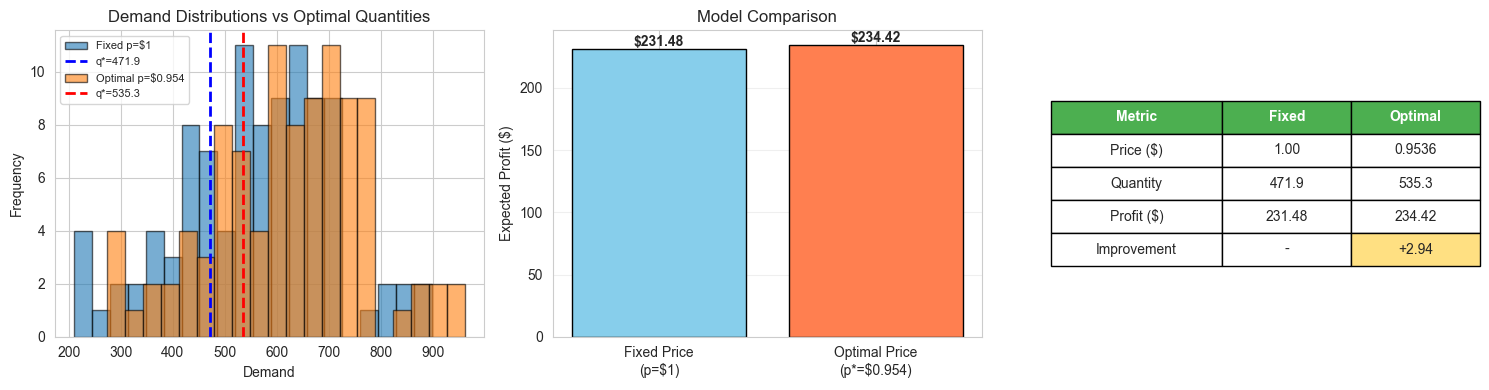

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Demand distributions
demand_fixed = result_fixed['demand']
demand_qp = beta_0 + beta_1 * result_qp['p_star'] + residuals

axes[0].hist(demand_fixed, bins=20, alpha=0.6, label=f'Fixed p=$1', edgecolor='black')
axes[0].axvline(result_fixed['q_star'], color='blue', linestyle='--', linewidth=2, label=f"q*={result_fixed['q_star']:.1f}")
axes[0].hist(demand_qp, bins=20, alpha=0.6, label=f'Optimal p=${result_qp["p_star"]:.3f}', edgecolor='black')
axes[0].axvline(result_qp['q_star'], color='red', linestyle='--', linewidth=2, label=f"q*={result_qp['q_star']:.1f}")
axes[0].set_xlabel('Demand')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Demand Distributions vs Optimal Quantities')
axes[0].legend(fontsize=8)

# Plot 2: Profit comparison
models = ['Fixed Price\n(p=$1)', 'Optimal Price\n(p*=${:.3f})'.format(result_qp['p_star'])]
profits = [result_fixed['profit'], result_qp['profit']]
bars = axes[1].bar(models, profits, color=['skyblue', 'coral'], edgecolor='black')
for bar, profit in zip(bars, profits):
    axes[1].text(bar.get_x() + bar.get_width()/2, profit, f'${profit:.2f}', 
                ha='center', va='bottom', fontweight='bold')
axes[1].set_ylabel('Expected Profit ($)')
axes[1].set_title('Model Comparison')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Summary table
axes[2].axis('off')
table_data = [
    ['Metric', 'Fixed', 'Optimal'],
    ['Price ($)', '1.00', f"{result_qp['p_star']:.4f}"],
    ['Quantity', f"{result_fixed['q_star']:.1f}", f"{result_qp['q_star']:.1f}"],
    ['Profit ($)', f"{result_fixed['profit']:.2f}", f"{result_qp['profit']:.2f}"],
    ['Improvement', '-', f"+{result_qp['profit']-result_fixed['profit']:.2f}"]
]
table = axes[2].table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
table[(4, 2)].set_facecolor('#FFE082')

plt.tight_layout()
plt.savefig('model_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Step 6-7: Bootstrap Analysis

Quantify uncertainty in optimal decisions

In [6]:
def bootstrap_analysis(data, n_bootstrap=1000):
    """Bootstrap resampling to assess decision uncertainty."""
    results = {'prices': [], 'quantities': [], 'profits': []}
    n = len(data)
    
    print(f"Running {n_bootstrap} bootstrap iterations...")
    for i in range(n_bootstrap):
        if (i+1) % 200 == 0:
            print(f"  {i+1}/{n_bootstrap}")
        
        # Resample with replacement
        sample = data.sample(n=n, replace=True)
        X_boot = sample['price'].values.reshape(-1, 1)
        y_boot = sample['demand'].values
        
        # Refit regression
        reg_boot = LinearRegression().fit(X_boot, y_boot)
        b0 = reg_boot.intercept_
        b1 = reg_boot.coef_[0]
        resid = y_boot - reg_boot.predict(X_boot)
        
        # Solve QP
        try:
            res = solve_price_endogenous_qp(resid, b0, b1)
            results['prices'].append(res['p_star'])
            results['quantities'].append(res['q_star'])
            results['profits'].append(res['profit'])
        except:
            continue
    
    return {k: np.array(v) for k, v in results.items()}

# Run bootstrap
boot_results = bootstrap_analysis(data, n_bootstrap=1000)

print(f"\n=== Bootstrap Results (n={len(boot_results['prices'])}) ===")
print(f"\nOptimal Price:")
print(f"  Mean: ${np.mean(boot_results['prices']):.4f}")
print(f"  95% CI: [${np.percentile(boot_results['prices'], 2.5):.4f}, ${np.percentile(boot_results['prices'], 97.5):.4f}]")
print(f"\nOptimal Quantity:")
print(f"  Mean: {np.mean(boot_results['quantities']):.2f}")
print(f"  95% CI: [{np.percentile(boot_results['quantities'], 2.5):.2f}, {np.percentile(boot_results['quantities'], 97.5):.2f}]")
print(f"\nExpected Profit:")
print(f"  Mean: ${np.mean(boot_results['profits']):.2f}")
print(f"  95% CI: [${np.percentile(boot_results['profits'], 2.5):.2f}, ${np.percentile(boot_results['profits'], 97.5):.2f}]")

Running 1000 bootstrap iterations...
  200/1000
  400/1000
  600/1000
  800/1000
  1000/1000

=== Bootstrap Results (n=1000) ===

Optimal Price:
  Mean: $0.9545
  95% CI: [$0.9299, $0.9809]

Optimal Quantity:
  Mean: 535.81
  95% CI: [477.60, 600.81]

Expected Profit:
  Mean: $235.09
  95% CI: [$218.14, $252.85]


## Step 8: Bootstrap Visualizations

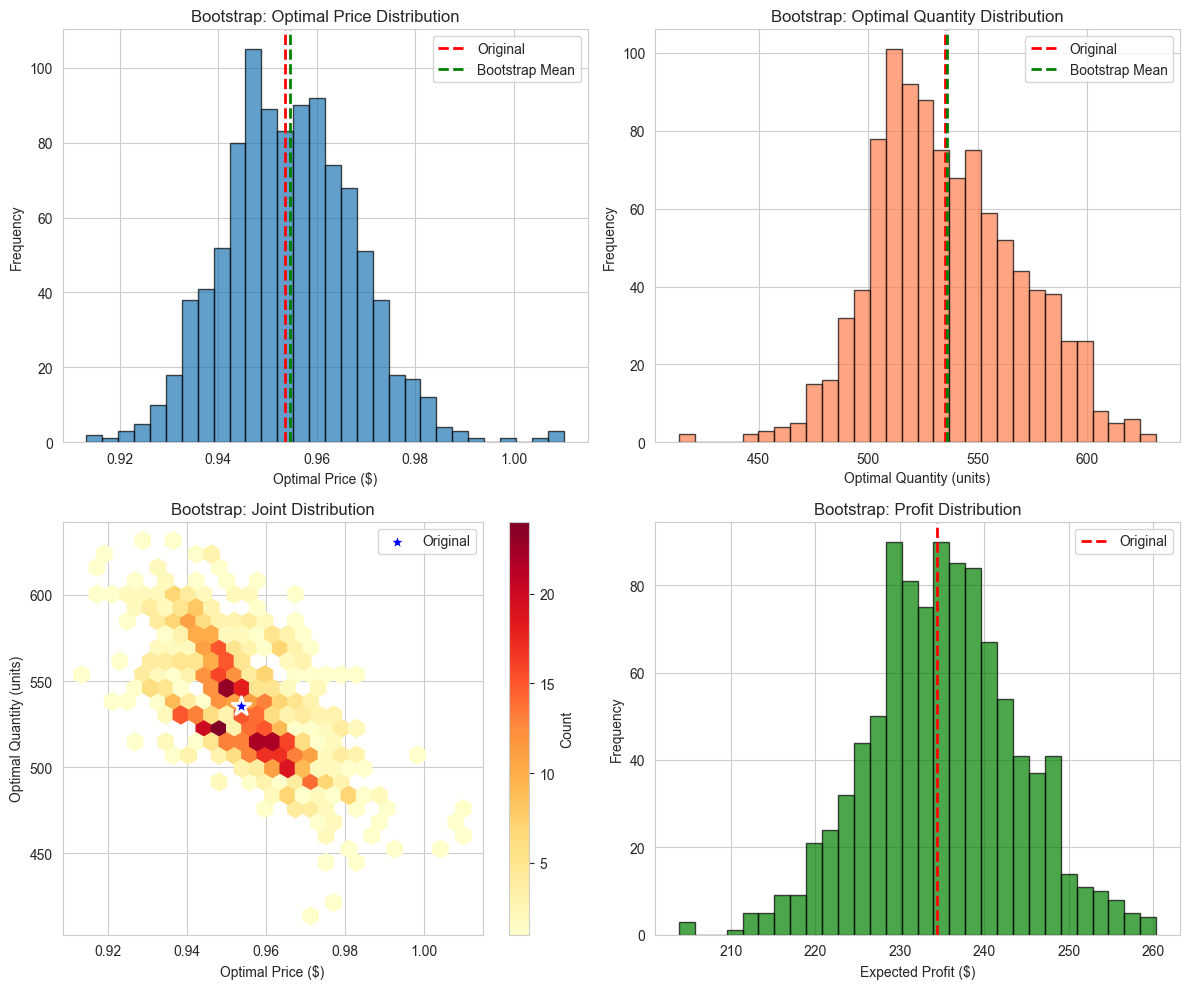

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Price distribution
axes[0, 0].hist(boot_results['prices'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(result_qp['p_star'], color='red', linestyle='--', linewidth=2, label='Original')
axes[0, 0].axvline(np.mean(boot_results['prices']), color='green', linestyle='--', linewidth=2, label='Bootstrap Mean')
axes[0, 0].set_xlabel('Optimal Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Bootstrap: Optimal Price Distribution')
axes[0, 0].legend()

# Quantity distribution
axes[0, 1].hist(boot_results['quantities'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(result_qp['q_star'], color='red', linestyle='--', linewidth=2, label='Original')
axes[0, 1].axvline(np.mean(boot_results['quantities']), color='green', linestyle='--', linewidth=2, label='Bootstrap Mean')
axes[0, 1].set_xlabel('Optimal Quantity (units)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Bootstrap: Optimal Quantity Distribution')
axes[0, 1].legend()

# Joint distribution
axes[1, 0].hexbin(boot_results['prices'], boot_results['quantities'], gridsize=25, cmap='YlOrRd', mincnt=1)
axes[1, 0].scatter([result_qp['p_star']], [result_qp['q_star']], color='blue', s=200, marker='*', 
                   edgecolors='white', linewidth=2, label='Original', zorder=5)
axes[1, 0].set_xlabel('Optimal Price ($)')
axes[1, 0].set_ylabel('Optimal Quantity (units)')
axes[1, 0].set_title('Bootstrap: Joint Distribution')
axes[1, 0].legend()
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Count')

# Profit distribution
axes[1, 1].hist(boot_results['profits'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(result_qp['profit'], color='red', linestyle='--', linewidth=2, label='Original')
axes[1, 1].set_xlabel('Expected Profit ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Bootstrap: Profit Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('bootstrap_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Recommendations

### Key Findings:
1. **Price Optimization Matters**: Joint price-quantity optimization yields significant profit improvement over fixed pricing
2. **Bootstrap Confidence**: 95% confidence intervals quantify decision uncertainty
3. **Trade-offs**: Rush/disposal costs create asymmetric incentives affecting optimal production

### Business Recommendations:
- Implement dynamic pricing to capture additional profit
- Monitor demand elasticity (β₁) for model recalibration
- Use bootstrap CI for risk-adjusted decision making